In [1]:
import pprint
import time
from pathlib import Path

import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import GroupKFold

from src.seed import seed_everything

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: regression
    metric: rmse
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.05
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
cb:
  params:
    loss_function: RMSE
    eval_metric: RMSE
    learning_rate: 0.05
    depth: 5
    max_leaves: 31
    min_data_in_leaf: 20
    subsample: 0.8
    rsm: 0.8
    l2_leaf_reg: 1
    random_seed: 42
    allow_writing_files: false
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '002'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  anime_path: ../../data/anime.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/002/base
seed

### Import

In [2]:
train_df = pd.read_csv(cfg.data.train_path)
anime_df = pd.read_csv(cfg.data.anime_path)
test_df = pd.read_csv(cfg.data.test_path)

train_df = train_df.merge(anime_df, how="left", on="anime_id")
test_df = test_df.merge(anime_df, how="left", on="anime_id")
all_df = pd.concat([train_df, test_df])

features = [col for col in train_df.columns if col != cfg.target]
num_features = train_df[features].select_dtypes(exclude="object").columns.tolist()
cat_features = train_df[features].select_dtypes(include="object").columns.tolist()


### 特徴量加工

In [3]:
# CountEncoding. all_dfで集計していることに注意
for col in cat_features:
    count_map = all_df[col].value_counts()
    train_df[f"count_{col}"] = train_df[col].map(count_map)
    test_df[f"count_{col}"] = test_df[col].map(count_map)

# GroupbyEncoding. all_dfで集計していることに注意
methods = ["mean", "std", "min", "max", "median"]
for grp_col in cat_features:
    grp_df = all_df.groupby(grp_col)[num_features].agg(methods).reset_index()
    grp_df.columns = [grp_col] + [f"grpby_{grp_col}_{col}_{m}" for m in methods for col in num_features]
    train_df = train_df.merge(grp_df, how="left", on=grp_col)
    test_df = test_df.merge(grp_df, how="left", on=grp_col)

# CategoryEncoding
for col in cat_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")


### 学習

In [4]:
x_train = train_df.drop([cfg.target, "user_id"], axis=1)
y_train = train_df[cfg.target]
groups = train_df["user_id"]
kf = GroupKFold(n_splits=cfg.n_splits)

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
cb_data = cb.Pool(
    data=x_train,
    label=y_train,
    cat_features=x_train.select_dtypes(include=["category"]).columns.tolist(),
)

# 学習
cv_results = cb.cv(
    cb_data,
    dict(cfg.cb.params),
    folds=kf.split(x_train, y_train, groups=groups),
    num_boost_round=cfg.cb.num_boost_round,
    early_stopping_rounds=cfg.cb.early_stopping_rounds,
    stratified=None,
    verbose_eval=cfg.cb.log_evaluation,
    seed=cfg.seed,
    return_models=True,
)

# 学習モデル保存
models = cv_results[1]
for i, model in enumerate(models):
    model.save_model(f"{cfg.data.results_dir}/model_fold={i}.pkl")


Training on fold [0/5]
0:	learn: 7.5477871	test: 7.5240701	best: 7.5240701 (0)	total: 124ms	remaining: 14d 9h 39m 32s
100:	learn: 1.4102000	test: 1.3898189	best: 1.3898189 (100)	total: 7.5s	remaining: 8d 14h 7m 54s
200:	learn: 1.3445912	test: 1.3791832	best: 1.3783032 (189)	total: 14.9s	remaining: 8d 13h 33m 49s
300:	learn: 1.3033938	test: 1.3798296	best: 1.3782471 (222)	total: 22.5s	remaining: 8d 15h 28m 28s

bestTest = 1.378247116
bestIteration = 222

Training on fold [1/5]
0:	learn: 7.5307460	test: 7.5968428	best: 7.5968428 (0)	total: 79.2ms	remaining: 9d 3h 54m 11s
100:	learn: 1.3974642	test: 1.4254552	best: 1.4254552 (100)	total: 7.86s	remaining: 9d 14m 41s
200:	learn: 1.3365482	test: 1.4161756	best: 1.4148348 (171)	total: 15.9s	remaining: 9d 3h 33m 28s

bestTest = 1.414834812
bestIteration = 171

Training on fold [2/5]
0:	learn: 7.5462882	test: 7.5302805	best: 7.5302805 (0)	total: 80.1ms	remaining: 9d 6h 27m 27s
100:	learn: 1.3976133	test: 1.4224100	best: 1.4224100 (100)	total: 7

### log

In [5]:
cv_data = cv_results[0]
best_iteration = np.argmin(cv_data["test-RMSE-mean"])
best_score = cv_data["test-RMSE-mean"].iloc[best_iteration - 1]
best_score_std = cv_data["test-RMSE-std"].iloc[best_iteration - 1]

with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write(f"best_score_std: {best_score_std}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(models[0].feature_names_))


### Feature Importance

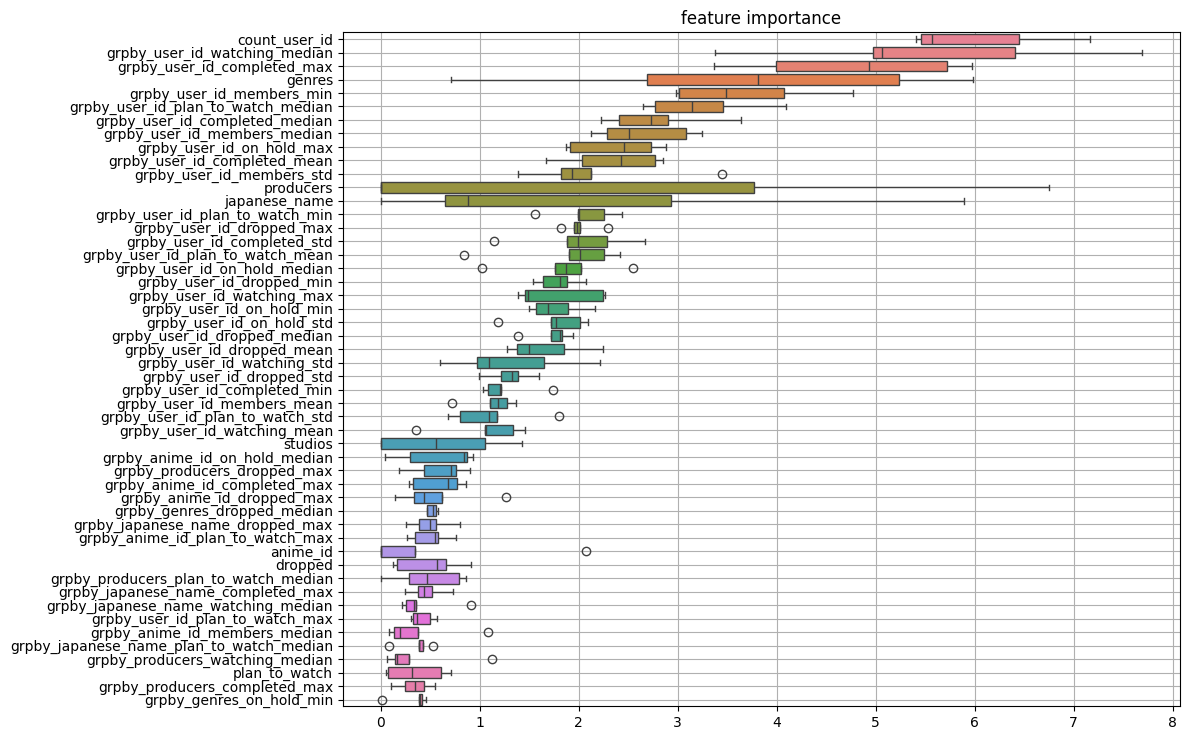

In [6]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = [model.get_feature_importance(cb_data) for model in models]
importance_df = pd.DataFrame(data=raw_importances, columns=models[0].feature_names_)

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### oof

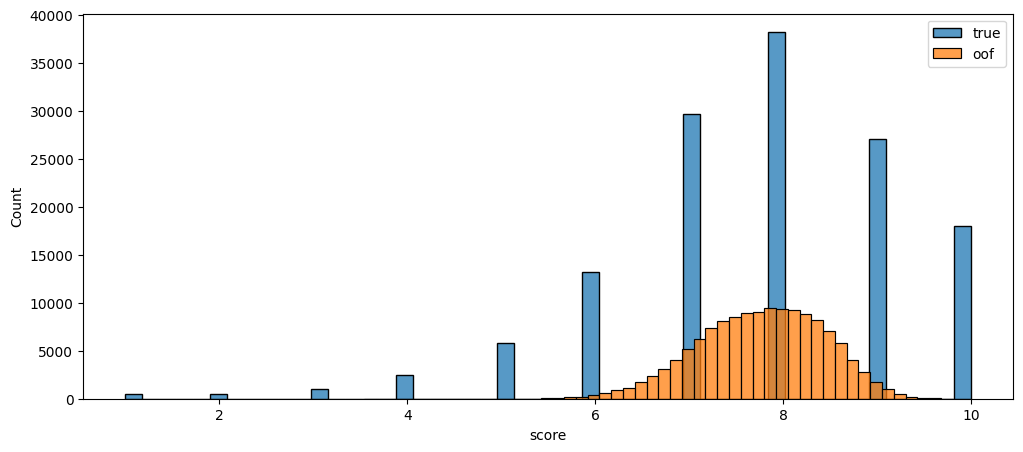

In [7]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(kf.split(x_train, y_train, groups=groups)):
    x_valid = x_train.iloc[valid_idx]
    model = models[i]
    y_pred = model.predict(x_valid, ntree_end=best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### Submission

In [8]:
# 推論
x_test = test_df.drop(["user_id"], axis=1)
y_preds = [model.predict(x_test, ntree_end=best_iteration) for model in models]
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df[cfg.target] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,score
0,8.623074
1,8.693579
2,7.375381
3,8.150036
4,6.676297
